# M3 Agentic AI - Email assistant workflow

## 1. Introduction

### 1.1 Lab overview

In an earlier video in this module, Andrew showed the example of a calendar assistant that could use multiple tools to carry out complex tasks. In this ungraded lab, you’ll explore a similar example - working with an **email assistant agent**. 

This agentic workflow can carry out various tasks related to email management, including sending emails, searching for emails from a specific sender, and deleting emails. You’ll give it natural language instructions - like “check unread emails from my boss” or “delete the Happy Hour email” - and see how it selects the right tools and completes the task for you.

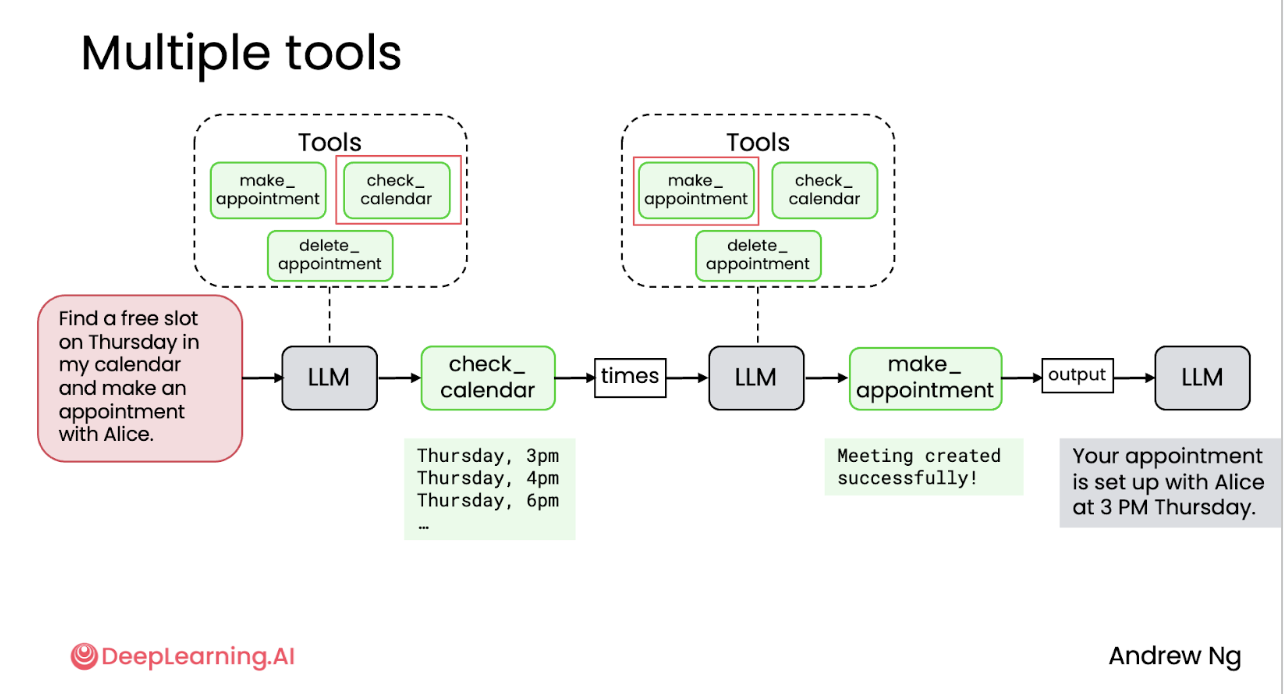

### 🎯 1.2 Learning outcome
By the end of this lab, you will be able to **connect an LLM to tools** with AISuite, give natural language instructions, and observe how the agent selects, executes, and validates multi-step tasks such as searching, sending, and deleting emails.


## 2. Initialize environment and client

As in previous lab, you will now set up the environment.  

In [1]:
# ================================
# Imports
# ================================

# --- Third-party ---
from dotenv import load_dotenv
import aisuite as ai
import json

# --- Local / project ---
import utils
import display_functions
import email_tools



# ================================
# Environment & Client
# ================================
load_dotenv()          # Load environment variables from .env
client = ai.Client()   # Initialize AISuite client


## 3. Simulated email service

### 3.1 Components
This lab uses a **simulated email backend** to mimic real-world email interactions.
Think of it as your personal sandbox email inbox: it comes preloaded with messages so you can practice without sending real emails.  

Instead of building this backend from scratch, you’ll be using tools that let you interact with it directly. Behind the scenes, it uses:

| Layer                   | Purpose                        |
|-------------------------|--------------------------------|
| **FastAPI**             | Exposes REST endpoints         |
| **SQLite + SQLAlchemy** | Stores and queries emails locally |
| **Pydantic**            | Ensures inputs and outputs are valid |
| **AISuite tools**       | Bridge between the LLM and the service |


### 3.2 Endpoints
The service provides several routes that simulate common email actions.  
Later on, these will be wrapped as tools so the assistant can use them automatically:

- `POST /send` → send a new email  
- `GET /emails` → list all emails  
- `GET /emails/unread` → show only unread emails  
- `GET /emails/{id}` → fetch a specific email by ID  
- `GET /emails/search?q=...` → search emails by keyword  
- `GET /emails/filter` → filter by recipient or date range  
- `PATCH /emails/{id}/read` → mark an email as read  
- `PATCH /emails/{id}/unread` → mark an email as unread  
- `DELETE /emails/{id}` → delete an email by ID  
- `GET /reset_database` → reset emails to initial state (for testing)  


> 💡 **Key idea:** These endpoints act as the “inbox controls.”  
> In the next steps, you’ll expose them as Python functions (tools) that the LLM can call—turning raw routes into agent actions.

### 3.3 Endpoint test helpers
Before giving control to the LLM, you’ll first **test the backend yourself**.  
The `utils.test_*` functions are quick wrappers around the API endpoints. They let you try actions like **send, list, search, filter, mark, and delete** without writing raw HTTP requests.

_**Note:** find the utils.py file from the top menu by navigating to File > Open_

Each helper has a clear, self-explanatory name. In the next cell code, you can uncomment the one you want to run, check their output, and confirm that the email service behaves as expected.  

For example, you can test:  
- Send a test email  
- Fetch email by ID  
- List all messages  
- Mark email as read or unread  
- Delete email  

This step is your **sanity check** before handing the controls over to the agent. It gives you confidence that the simulated email service is alive and behaving just like a real email service would.

👉 To test the endpoints, **uncomment** the lines you’d like to try out, run the cell, and check the results instantly.

In [2]:
# uncomment the line 'utils.test_*' you want to try
new_email_id = utils.test_send_email()
_ = utils.test_get_email(new_email_id['id'])
#_ = utils.test_list_emails()
#_ = utils.test_filter_emails(recipient="test@example.com")
#_ = utils.test_search_emails("lunch")
#_ = utils.test_unread_emails()
#_ = utils.test_mark_read(new_email_id['id'])
#_ = utils.test_mark_unread(new_email_id['id'])
#_ = utils.test_delete_email(new_email_id['id'])
#_ = utils.reset_database()


## 4. Tool layer for the email agent

### 4.1 Why tools?
Now that the endpoints are working, the next step is to expose them to the LLM as Python functions called **tools**. Each tool wraps a REST route, transforming raw API calls into actions the agent can perform—like list, read, search, send, delete, or toggle read.

> Think of tools as the agent’s **actuators**: you give a natural language instruction (“check unread emails from my boss and send a polite reply”), and the model chooses **which tools** to call and **in what order** to complete the task.

### 4.2 Design hints
- Keep tool **docstrings** short, imperative, and specific to the action.  
- Return **consistent, compact JSON** so the model can chain results.  
- Prefer **one clear responsibility per tool** (single route, single effect).

### 4.3 Available tools
| Tool Function                      | Action                                                                 |
|------------------------------------|------------------------------------------------------------------------|
| `list_all_emails()`                | Fetch all emails, newest first                                         |
| `list_unread_emails()`             | Retrieve only unread emails                                            |
| `search_emails(query)`             | Search by keyword in subject, body, or sender                          |
| `filter_emails(...)`               | Filter by recipient and/or date range                                  |
| `get_email(email_id)`              | Fetch a specific email by ID                                           |
| `mark_email_as_read(id)`           | Mark an email as read                                                  |
| `mark_email_as_unread(id)`         | Mark an email as unread                                                |
| `send_email(...)`                  | Send a new (simulated) email                                                |
| `delete_email(id)`                 | Delete an email by ID                                                  |
| `search_unread_from_sender(addr)`  | Return unread emails from a given sender (e.g., `boss@email.com`)      |

**Note:** find the email_tools.py file from the top menu by navigating to File > Open.

For example, **testing `list_all_emails()` tool:**
```python
    all_emails = email_tools.list_all_emails()
```

Now, let’s try out a few tools that connect to the simulated endpoints to make sure everything is working. 

👉 **Uncomment** the ones you’d like to run, execute the cell, and review the outputs.

In [3]:
# Test sending a new email and fetch it by ID
new_email = email_tools.send_email("test@example.com", "Lunch plans", "Shall we meet at noon?")
content_ = email_tools.get_email(new_email['id'])

# Uncomment the ones you want to try:
#content_ = email_tools.list_all_emails()
#content_ = email_tools.list_unread_emails()
#content_ = email_tools.search_emails("lunch")
#content_ = email_tools.filter_emails(recipient="test@example.com")
#content_ = email_tools.mark_email_as_read(new_email['id'])
#content_ = email_tools.mark_email_as_unread(new_email['id'])
#content_ = email_tools.search_unread_from_sender("test@example.com")
#content_ = email_tools.delete_email(new_email['id'])

utils.print_html(content=json.dumps(content_, indent=2), title="Testing the email_tools")


## 5. Preparing the agent prompt

Before assigning tasks to the email assistant agent, you’ll create a small helper function called `build_prompt()`. 
This function wraps the natural language request in a system-style preamble so the LLM:

- Recognizes that it’s acting as an **email assistant agent**  
- Understands it has permission to use the available tools  
- Executes actions directly, without asking for confirmation (no human-in-the-loop)

In [4]:
def build_prompt(request_: str) -> str:
    return f"""
- You are an AI assistant specialized in managing emails.
- You can perform various actions such as listing, searching, filtering, and manipulating emails.
- Use the provided tools to interact with the email system.
- Never ask the user for confirmation before performing an action.
- If needed, my email address is "you@email.com" so you can use it to send emails or perform actions related to my account.

{request_.strip()}
"""

Run the next cell to see how the previous function **wraps your raw user prompt** with system instructions.
For example:

In [5]:
example_prompt = build_prompt("Delete the Happy Hour email")
utils.print_html(content=example_prompt, title="Example example_prompt")


### 5.3 Resetting the email service

Since you’ve been experimenting with the email service, let’s reset it back to its initial state.

You can do this by calling the utility function that clears and refreshes the simulated email service:

In [6]:
utils.reset_database()

{'message': 'Database reset and emails reloaded'}

## 6. LLM + Email tools

### 6.1 Scenario
So far, you’ve been working directly with the backend. Now it’s time to let the **LLM take control** as your email assistant agent.

For example, you might ask it:
> “Check for unread emails from `boss@email.com`, mark them as read, and send a polite follow-up.”

### 6.2 What happen
1. The agent interprets your instruction.  
2. It selects the right tools (`search_unread_from_sender` → `mark_email_as_read` → `send_email`).  
3. It executes each action automatically, without asking for confirmation.

AISuite handles schema exposure, argument binding, execution, and passing results between steps—so you can focus on **what** the agent achieves, not **how** to call the API.

### 6.3 Run it
Run the next cell and see how the agent orchestrates multiple tools to fulfill your request. Feel free to try your own requests with the email service as well.

*What to look for:*
- A clear **tool-call trace** showing which tools were used and the arguments passed.
- A concise **final message** summarizing the actions performed (e.g., “Found 1 unread email, marked as read, sent follow-up”).

In [7]:
# Try your own requests
prompt_ = build_prompt("Check for unread emails from boss@email.com, mark them as read, and send a polite follow-up.")

response = client.chat.completions.create(
    model="openai:gpt-4.1", # LLM
    messages=[{"role": "user", "content": (
        prompt_
    )}],
    tools=[ # list of tools that the LLM can access
        email_tools.search_unread_from_sender,
        email_tools.list_unread_emails,
        email_tools.search_emails,
        email_tools.get_email,
        email_tools.mark_email_as_read,
        email_tools.send_email
    ],
    max_turns=5,
)

display_functions.pretty_print_chat_completion(response)



### 6.4. Missing tool: `delete_email`

What happens if the tool you need isn’t available?  

For example, try this request:  
> “Delete alice@work.com’s email.”

Since the `delete_email` tool is not registered, the LLM will still attempt to respond, but it won’t be able to complete the action.   

<div style="background-color: #ffe4e1; padding: 12px; border-radius: 6px; color: black;">
  <h4>🔍 Key Insight</h4>
  <p style="margin: 0;">
    This highlights an important point: <b>the tools you make available directly determine what the agent can do.</b>
  </p>
</div>


**Available tools**

| Tool Function                      | Action                                                                 |
|------------------------------------|------------------------------------------------------------------------|
| `list_all_emails()`                | Fetch all emails, newest first                                         |
| `list_unread_emails()`             | Retrieve only unread emails                                            |
| `search_emails(query)`             | Search by keyword in subject, body, or sender                          |
| `filter_emails(...)`               | Filter by recipient and/or date range                                  |
| `get_email(email_id)`              | Fetch a specific email by ID                                           |
| `mark_email_as_read(id)`           | Mark an email as read                                                  |
| `mark_email_as_unread(id)`         | Mark an email as unread                                                |
| `send_email(...)`                  | Send a new (mock) email                                                |
| `delete_email(id)`                 | Delete an email by ID                                                  |
| `search_unread_from_sender(addr)`  | Return unread emails from a given sender (e.g., `boss@email.com`)      |





In [8]:
# Try with a request that may call an unavailable tool
prompt_ = build_prompt("Delete alice@work.com email")

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt_
    )}],
    tools=[ # list of tools that the LLM can access
        email_tools.search_unread_from_sender,
        email_tools.list_unread_emails,
        email_tools.search_emails,
        email_tools.get_email,
        email_tools.mark_email_as_read,
        email_tools.send_email
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)


#### 6.4.1 Try again with `delete_email` enabled

What happens if the tool you need isn’t available?

In the previous step of the lab, you gave the LLM access to the following list of tools:
```python
    tools=[
        email_tools.search_unread_from_sender,
        email_tools.list_unread_emails,
        email_tools.search_emails,
        email_tools.get_email,
        email_tools.mark_email_as_read,
        email_tools.send_email
    ]
```

And because of the tools available in that list, the agent couldn’t delete emails because the `delete_email` tool wasn’t available.

Now add `delete_email` to the tool list and re-run the cell. This time, the agent has everything it needs to finish the task.  

> Tip: Watch the sequence of calls — after finding the target message, the agent should select `delete_email` to complete the action.


In [9]:
prompt_ = build_prompt("Delete alice@work.com email")

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt_
    )}],
    tools=[
        email_tools.search_unread_from_sender,
        email_tools.list_unread_emails,
        email_tools.search_emails,
        email_tools.get_email,
        email_tools.mark_email_as_read,
        email_tools.send_email,
        email_tools.delete_email
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)


### 6.5. Targeted action: Delete the “Happy Hour” email

The test inbox comes preloaded with a message titled **“Happy Hour.”**  Your task is to instruct the agent to locate this message and delete it.

For reference, here’s the entry from the mock dataset:

```json
{
  "id": 1,
  "sender": "eric@work.com",
  "recipient": "you@email.com",
  "subject": "Happy Hour",
  "body": "We're planning drinks this Friday!",
  "timestamp": "2025-06-13T04:48:59.096908",
  "read": false
}
````
Run the next cell and watch how the agent searches for the message and deletes it from the inbox.

In [10]:
prompt_ = build_prompt("Delete the happy hour email")

response = client.chat.completions.create(
    model="openai:o4-mini",
    messages=[{"role": "user", "content": (
        prompt_
    )}],
    tools=[
        email_tools.search_unread_from_sender,
        email_tools.list_unread_emails,
        email_tools.search_emails,
        email_tools.get_email,
        email_tools.mark_email_as_read,
        email_tools.send_email,
        email_tools.delete_email
    ],
    max_turns=5
)

display_functions.pretty_print_chat_completion(response)

## 7. Final Takeaways

- In this ungraded lab, **you explored** how an LLM email agent interacts with a simulated email service using tool calls.
- **Tool calling** allows LLMs to go beyond text generation—enabling them to call functions (tools) and complete multi-step tasks.
- The set of available tools determines what the agent can and cannot do (e.g., without `delete_email`, it cannot remove messages).
- Clear docstrings and consistent behavior help the LLM select the right tool for each step.
- AISuite manages the interaction layer: exposing Python functions as tools, accepting parameters, making API requests, and returning results.
- Observing the full workflow—from prompt → tool calls → outputs → final response—is key to understanding and improving how agents reason and act.

<div style="border:1px solid #22c55e; border-left:6px solid #16a34a; background:#dcfce7; border-radius:6px; padding:14px 16px; color:#064e3b; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">

🎉 <strong>Congratulations!</strong>

You just guided an LLM-powered <em>email assistant agent</em> from natural language requests to concrete actions on a simulated email service. You saw how tools turn plain language into reliable operations—listing, searching, marking as read, sending, and deleting—without you touching raw HTTP requests. 

You learned that the tools you expose define the agent’s real capabilities. When a tool is missing, the agent can reason but cannot act; when it’s present, it can chain steps, pass parameters, and deliver exactly what you asked for. Along the way, AISuite handled the plumbing: schema exposure, argument binding, execution, and result passing—so you could focus on what you wanted done, not how to wire it up.

With this workflow under your belt, you’re ready to design task-focused agents that act safely and transparently, explain what they did, and scale from simple prompts to dependable multi-step automation across your own services. 🌟
</div>